#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

#from bvcopula import SingleParamCopulaBase
from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel
from bvcopula import Mixed_GPInferenceModel, GridInterpolationVariationalStrategy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

animal = 'ST263'
day_name = 'Day4'
path = '/home/nina/VRData/Processing/pkls'

with open("{}/{}_{}_signals.pkl".format(path,animal,day_name),'rb') as f:
    signal_pkl = pkl.load(f)
with open("{}/{}_{}_behaviour.pkl".format(path,animal,day_name),'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

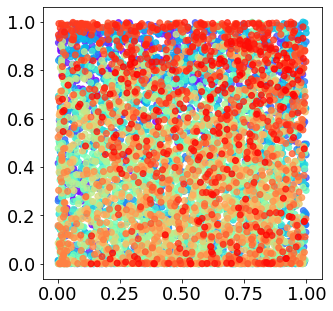

In [221]:
signals = signal_pkl['signals_transformed']
n1 = 6
n2 = 6
#Y_all = np.array([signals[n1],signals[n2]]).T
name1, name2 = 'Velocity', 'Neuron 6'
Y_all = np.array([behaviour_pkl['transformed_velocity'],signals[n1]]).T
X_all = np.array(behaviour_pkl['position'])#local_time
ve = np.array(behaviour_pkl['velocity'])

rule = (Y_all[:,0]>1e-4) & (Y_all[:,1]>1e-4)  \
        & (Y_all[:,0]<1.-1e-4) & (Y_all[:,1]<1.-1e-4)#\
        #& (X_all > 120.)#& (time>7*60)
    
ve = ve[rule]
trials = behaviour_pkl['trials'][rule]
 
X = np.reshape(X_all[rule],(-1,1))
X[X<0] = 160.+X[X<0]
X[X>160] = X[X>160]-160.
X = X/160.
Y = Y_all[rule]

NSamp = X.shape[0]
plt.figure(figsize=(5,5))
colors = cm.rainbow(np.linspace(0., 1., NSamp))
skip = 3
plt.scatter(*Y[::skip].T, color=colors[::skip], alpha=0.8)

# X = np.flip(X,axis=0).copy()
# Y = np.flip(Y,axis=0).copy()

In [259]:
trial_weights = np.zeros_like(trials)
for i, v in enumerate(trials):
    trial_weights[i] = (len(trials)/trials[-1])*1./np.count_nonzero(trials==v)

In [260]:
a = ['a','b','d','c']
a[:-1]

['a', 'b', 'd']

In [261]:
elements = [GaussianCopula_Likelihood(),
            FrankCopula_Likelihood(),
            ClaytonCopula_Likelihood(rotation='0°'),
            ClaytonCopula_Likelihood(rotation='90°'),
            ClaytonCopula_Likelihood(rotation='180°'),
            ClaytonCopula_Likelihood(rotation='270°'),
            GumbelCopula_Likelihood(rotation='0°'),
            GumbelCopula_Likelihood(rotation='90°'),
            GumbelCopula_Likelihood(rotation='180°'),
            GumbelCopula_Likelihood(rotation='270°')]
sequence = [GaussianCopula_Likelihood(), ClaytonCopula_Likelihood(rotation='0°')]
d={}
d['f']=1

In [262]:
likelihoods = [#FrankCopula_Likelihood(),
                GaussianCopula_Likelihood(),
                #ClaytonCopula_Likelihood(rotation='180°'),
                #ClaytonCopula_Likelihood(rotation='0°'),
                #GumbelCopula_Likelihood(rotation='0°'),
                ]

In [263]:
NSamp

19082

In [264]:
Y[Y!=Y]

array([], dtype=float64)

In [265]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)
weights = torch.tensor(trial_weights).float().cuda(device=0)

In [266]:
# define the model (optionally on GPU)
grid_size = 128#train_x.shape[0]
thetas_sharing = None#torch.tensor([0,1,2,1])
if thetas_sharing is not None:
    num_fs = len(likelihoods)+thetas_sharing.max().numpy() # indep_thetas + num_copulas - 1
else:
    num_fs = 2*len(likelihoods)-1
print(num_fs)
model = Mixed_GPInferenceModel(MixtureCopula_Likelihood(likelihoods, theta_sharing=thetas_sharing), 
                               num_fs,  
                               prior_rbf_length=0.5, grid_size=grid_size, grid_bonds=torch.tensor([[0.,1.]])).cuda(device=0)

1


In [267]:
from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from gpytorch import settings


class VariationalELBO(MarginalLogLikelihood):
    def __init__(self, likelihood, model, weights, num_data, combine_terms=True):
        """
        A special MLL designed for variational inference
        Args:
        - likelihood: (Likelihood) - the likelihood for the model
        - model: (Module) - the variational GP model
        - num_data: (int) - the total number of training data points (necessary for SGD)
        - combine_terms: (bool) - whether or not to sum the expected NLL with the KL terms (default True)
        """
        super(VariationalELBO, self).__init__(likelihood, model)
        self.combine_terms = combine_terms
        self.num_data = num_data
        self.weights = weights

    def forward(self, variational_dist_f, target, **kwargs):
        num_batch = variational_dist_f.event_shape.numel()

        log_likelihood = self.likelihood.expected_log_prob(target, variational_dist_f, 
                                                           weights=self.weights,
                                                           particles = torch.Size([0]),
                                                           **kwargs).div(num_batch)
        kl_divergence = self.model.variational_strategy.kl_divergence()

        if kl_divergence.dim() > log_likelihood.dim():
            kl_divergence = kl_divergence.sum(-1)

        if log_likelihood.numel() == 1:
            kl_divergence = kl_divergence.sum()

        kl_divergence = kl_divergence.div(self.num_data)

        # Add any additional registered loss terms
        added_loss = torch.zeros_like(kl_divergence)
        had_added_losses = False
        for added_loss_term in self.model.added_loss_terms():
            added_loss.add_(added_loss_term.loss())
            had_added_losses = True

        if self.combine_terms:
            res = log_likelihood - kl_divergence
            for _, prior, closure, _ in self.named_priors():
                res.add_(prior.log_prob(closure()).sum().div(self.num_data))
            return res + added_loss
        else:
            log_prior = torch.zeros_like(log_likelihood)
            for _, prior, closure, _ in self.named_priors():
                log_prior.add_(prior.log_prob(closure()).sum())
            if had_added_losses:
                return log_likelihood, kl_divergence, log_prior.div(self.num_data), added_loss
            else:
                return log_likelihood, kl_divergence, log_prior.div(self.num_data)

In [268]:
# train the model

torch.autograd.set_detect_anomaly(False)

base_lr = 1e-2
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

#torch.autograd.set_detect_anomaly(True)

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.variational_strategy.variational_distribution.variational_mean},
    #hyperparameters
    {'params': model.covar_module.raw_outputscale, 'lr': .001},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .001} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = VariationalELBO(model.likelihood, model, weights, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
            
        loss = -mll(output, train_y) 
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   length: {}, scale: {}, dLoss: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                model.covar_module.outputscale.detach().cpu().numpy().squeeze(),
                mean_p
            ))
            if (0 < mean_p < 0.0001):
                print("Converged!")
                break
            p = 0.

        # The actual optimization step
        loss.backward()
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        # strict
        assert torch.all(covar_grad==covar_grad)
        #light
#         if torch.any(covar_grad!=covar_grad):
#             for n, par in model.named_parameters():
#                 grad = par.grad.data
#                 #if torch.nonzero(grad!=grad).shape[0]!=0:
#                 #    print('NaN grad in {}'.format(n))
#                 nans+=torch.nonzero(grad!=grad).shape[0]
#                 if torch.any(grad.abs()==float('inf')):
#                     print("Grad inf... fixing...")
#                     grad = torch.clamp(grad,-1.,1.)
#                 grad[grad!=grad] = 0.0
#                 par.grad.data = grad
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: -0.00518   length: 0.47406062483787537, scale: 0.7297074198722839, dLoss: 0.0
Iter 200/2000 - Loss: -0.00925   length: 0.45210182666778564, scale: 0.7594503164291382, dLoss: 0.0188
Iter 300/2000 - Loss: -0.00951   length: 0.4214380979537964, scale: 0.799251914024353, dLoss: 0.000556
Iter 400/2000 - Loss: -0.00973   length: 0.3816356062889099, scale: 0.8520621061325073, dLoss: 9.47e-05
Converged!
CPU times: user 16.1 s, sys: 937 ms, total: 17 s
Wall time: 17 s


(400, 1, 128)


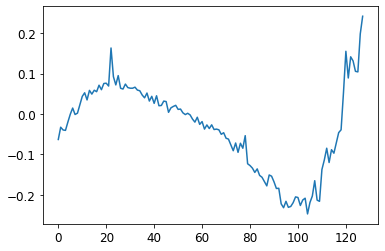

In [269]:
print(np.shape(means))
for i in range(num_fs):
    plt.plot(means[-1][i])
losses[losses!=losses] = 0

In [270]:
a = torch.Size([100])
b = torch.Size([0])
a<b

False

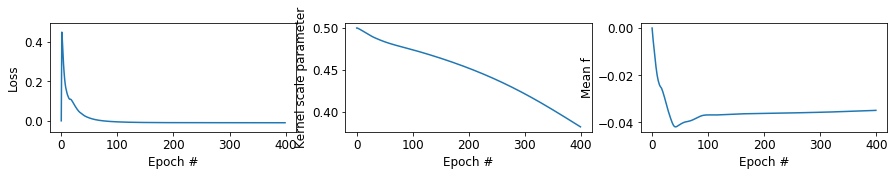

In [271]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
marg = (np.max(losses) - np.min(losses))*0.1
loss.set_ylim(np.min(losses)-marg,
              np.max(losses)+marg)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [272]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

In [273]:
import gc
gc.collect()
torch.cuda.empty_cache() 

gplink = model.likelihood.gplink_function
copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]

S=500
with torch.no_grad():
    f_samples = model(train_x).rsample(torch.Size([S]))
    thetas, mixes = gplink(f_samples)
    ###
#     samples = torch.empty_like(train_y).uniform_(1e-4, 1. - 1e-4)
#     null_log_prob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).\
#             log_prob(samples).detach().cpu().numpy()
#     null_pwaic = np.var(null_log_prob,axis=0).sum()
#     print('Null AIC: ', (null_log_prob.sum()/N - null_pwaic))
    ###
    log_prob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).\
            log_prob(train_y).detach().cpu().numpy()
    pwaic = np.var(log_prob,axis=0).sum()
    sum_prob = np.exp(log_prob).sum(axis=0)
    lpd=np.sum(np.log(sum_prob)-np.log(S)) # sum_M log(1/N * sum^i_S p(y|theta_i)), where N is train_x.shape[0]
    ###
#     with gpytorch.settings.num_likelihood_samples(1):
#          y_sim = model.likelihood(model(train_x)).rsample()
#     self_log_prob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).\
#             log_prob(y_sim.squeeze()).detach().cpu().numpy()
#     self_pwaic = np.var(self_log_prob,axis=0).sum()
#     print('Self AIC: ', (self_log_prob.sum()/N - self_pwaic))
    ###
    #print('Log_probability: ',log_prob.sum())
    print('Lpd: ',lpd)
    print('p_WAIC: ',pwaic)
    print('WAIC: ', lpd - pwaic)

del(f_samples, log_prob)
torch.cuda.empty_cache() 
# model.likelihood.copula

Lpd:  336.37988
p_WAIC:  20.035944
WAIC:  316.34393


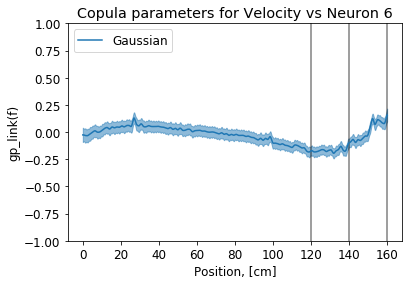

In [274]:
# visualize the result
fig = plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 12})

plt.axvline(120, color='black', alpha=0.5)
plt.axvline(140, color='black', alpha=0.5)
plt.axvline(160, color='black', alpha=0.5)

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)

copulas = [lik.name for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
 
for t,l,u,c,r in zip(thetas,thetas_low,thetas_upp,copulas,rotations):
    F_mean = t.detach().cpu().numpy()
    if r==None:
        label = '{}'.format(c)
    else:
        label = '{} {}'.format(c,r)
    line, = plt.plot(160*testX, F_mean, label = label)
    plt.fill_between(160*testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)
    
#plt.scatter(np.linspace(0., 160., NSamp),np.zeros(NSamp),color=colors)
plt.xlabel('Position, [cm]')
plt.ylabel('gp_link(f)')
plt.title('Copula parameters for {} vs {}'.format(name1,name2))
plt.ylim(-1.0,1.0)
plt.legend()

fig.show()

In [275]:
with gpytorch.settings.num_likelihood_samples(1):
    gplink = model.likelihood.gplink_function
    copulas = [lik.copula for lik in likelihoods]
    rotations = [lik.rotation for lik in likelihoods]
    thetas, mixes = gplink(model(test_x).mean)
    test_y = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).rsample()
    Y_sim = test_y.cpu().detach().numpy()
    #Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
    #Y_sim = norm.ppf(Y_sim)
    
X_pos = testX.squeeze()*160
Y_pos = Y_sim.squeeze()

64 4.1588830833596715


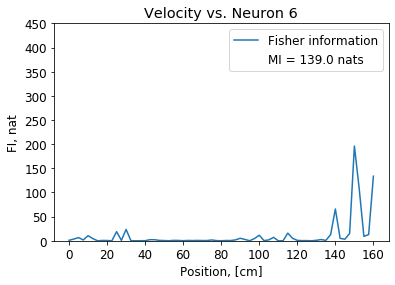

In [276]:
plt.rcParams.update({'font.size': 12})

ds = 2.5
n = int(160/ds)
samples = test_y
points = np.arange(n+1)/n

copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]

with torch.no_grad():
    thetas, mixes = gplink(model(torch.tensor(points).float().cuda(device=0)).mean)
    thetas = thetas.expand(samples.shape[:1]+thetas.shape)
    mixes = mixes.expand(samples.shape[:1]+mixes.shape)
    thetas = torch.einsum('ijk->jki', thetas) # now: [copulas, positions, samples]
    mixes = torch.einsum('ijk->jki', mixes)
    logprob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).log_prob(samples)
    #calculate FI
    FI = np.empty(n+1)
    FI[0] = ((logprob[0].exp())*((logprob[1]-logprob[0])/(ds/2)).pow(2)).sum().cpu().detach().numpy()
    FI[n] = ((logprob[n].exp())*((logprob[n]-logprob[n-1])/(ds/2)).pow(2)).sum().cpu().detach().numpy()
    for i in range(1,n):
        FI[i] = ((logprob[i].exp())*((logprob[i+1]-logprob[i-1])/ds).pow(2)).sum().cpu().detach().numpy()
    #now calculate MI    
    # P(r) = integral P(r|s) P(s) ds
    Pr = torch.zeros(samples.shape[0]).cuda(device=0)
    for i in range(n+1):
        Pr += logprob[i].exp().detach()*(1/(n+1))
    MIs=0
    for i in range(n+1):    
        MIs+= 1/(n+1)*logprob[i].exp()*(logprob[i]-Pr.log())
    MI = MIs.sum().detach().cpu().numpy()
    plt.plot(np.arange(n+1)*ds,FI,label='Fisher information')
    plt.plot(0,0,color='white',label='MI = {:.1f} nats'.format(MI))
    plt.title("{} vs. {}".format(name1,name2))
    plt.xlabel('Position, [cm]')
    plt.ylabel('FI, nat')
    plt.ylim(0,450)
    plt.legend()
print(n,np.log(n))

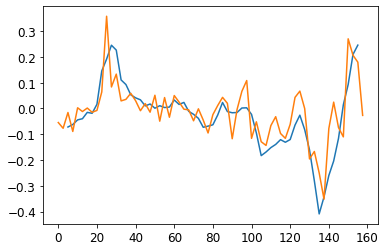

In [245]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau

x,p,k = [],[],[]

X_pos = X.squeeze()*160
Y_pos = Y#norm.ppf(Y)

for b in range(int(160/2.5)):
    dat = Y_pos[(X_pos>b*2.5) & (X_pos<(b+1)*2.5)]
    p.append(pearsonr(*dat.T)[0])
    k.append(kendalltau(*dat.T)[0])
    x.append((b+0)*2.5)
    
p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    
    
plt.plot(x[2:-1],p)
plt.plot(x,k)

x=x[2:-1]

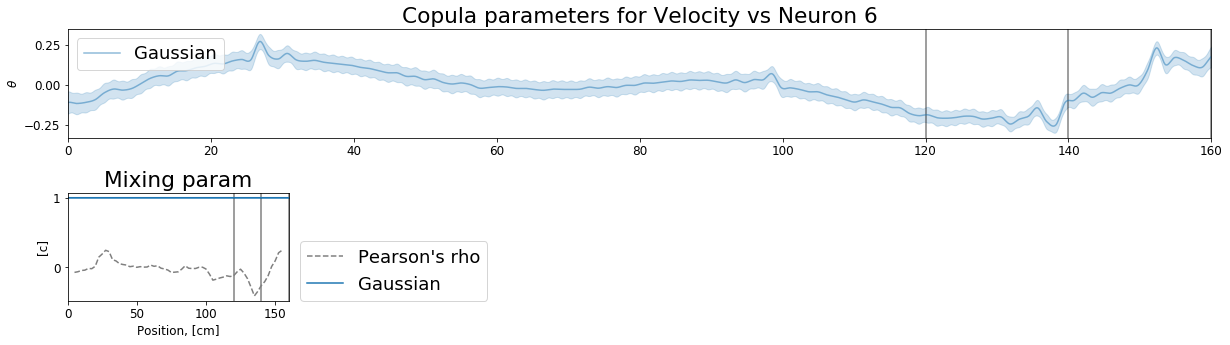

In [241]:
# visualize the result
fig, ax = plt.subplots(2,1,figsize=(20.5, 5))
ax_new = fig.add_axes([0.125,0.125,.15,.3])

plt.rcParams.update({'font.size': 18})

model.eval()
with torch.no_grad():
    output = model(test_x)
    
for a in [ax[0],ax_new]:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)

copulas = [lik.name for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
 
for t,l,u,c,r in zip(thetas,thetas_low,thetas_upp,copulas,rotations):
    F_mean = t.detach().cpu().numpy()
    if r==None:
        label = '{}'.format(c)
    else:
        label = '{} {}'.format(c,r)
    line, = ax[0].plot(testX*160, F_mean, label = label, alpha=0.5)
    ax[0].fill_between(testX*160, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.2)
    
#ax[0].scatter(np.linspace(0., 1., NSamp),np.zeros(NSamp),color=colors)

ax[0].set_ylabel(r'$\theta$')
ax[0].set_title('Copula parameters for {} vs {}'.format(name1,name2))
ax[0].set_xlim(0,160)
ax[0].legend(loc=2)

ax_new.plot(x,p, '--', color='grey', label='Pearson\'s rho')

_, sampled = gplink(output.rsample(torch.Size([100])))

for i, (t,c,r) in enumerate(zip(mixes[:],copulas,rotations)):
    F_mean = t.detach().cpu().numpy()
    if r==None:
        label = '{}'.format(c)
    else:
        label = '{} {}'.format(c,r)
    line, = ax_new.plot(testX*160, F_mean, label = label)
    sm = np.mean(sampled[i].cpu().numpy(),axis=0)
    std = np.std(sampled[i].cpu().numpy(),axis=0)
    ax_new.fill_between(testX*160, sm-std, sm+std, color=line.get_color(), alpha=0.5)

#ax[1].scatter(np.linspace(0., 160., NSamp),np.zeros(NSamp),color=colors)
ax[1].set_axis_off()
ax_new.set_xlabel('Position, [cm]')
ax_new.set_ylabel('[c]')
ax_new.set_title('Mixing param')
ax_new.set_xlim(0,160)
ax_new.legend(loc=(1.05,.0))

plt.subplots_adjust(hspace=0.5)

# plt.savefig('poster_img/res0_plot.pdf')
# plt.savefig('poster_img/res0_plot.svg')
#fig.show()

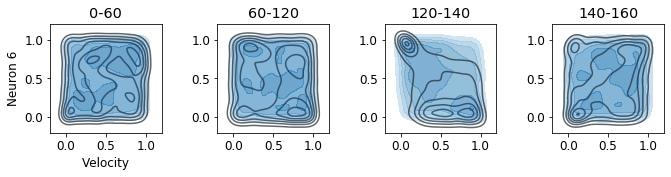

In [242]:
import seaborn as sns
from scipy.stats import norm

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(11,2))
fig.subplots_adjust(hspace=0.5)

axes[0].set_ylabel(name2)
axes[0].set_xlabel(name1)

X_pos = testX.squeeze()*160
Y_pos = Y_sim.squeeze()

mrg = .2

for s,e,ax,name in zip([0,60,120,140],[60,120,140,160],axes.flatten(),['0-60','60-120','120-140','140-160']): #['0-1','1-2','2-3','3-4']
    sns.kdeplot(*Y_pos[(X_pos[:]>=s) & (X_pos[:]<e)].T, ax=ax, shade=True,  shade_lowest=False, alpha=0.7, n_levels=6)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))
    
X_pos = X.squeeze()*160
Y_pos = Y#norm.ppf(Y)

for s,e,ax,name in zip([0,60,120,140],[60,120,140,160],axes.flatten(),['0-60','60-120','120-140','140-160']): #['0-1','1-2','2-3','3-4']
    sns.kdeplot(*Y_pos[(X_pos[:]>=s) & (X_pos[:]<e)].T, ax=ax, shade=False,  shade_lowest=False, alpha=0.7, color='#073763ff', n_levels=6)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))

plt.subplots_adjust(wspace=0.5)

# plt.savefig('poster_img/res0_copula.pdf')
# plt.savefig('poster_img/res0_copula.svg')